In [ ]:
#| default_exp mode_estimation

# Modified Efficient Importance Sampling

Modified efficient importance sampling is used to improve on mode estimation. The goal is to minimize the variance of log-weights in importance sampling [@Zhang2007Efficient,@Koopman2019Modified]. If the importance sampling model is a gaussian one where observations are conditionally independent across time and space, its iterations reduce to a least squares problem which can be solved efficiently.

$$
\int \left(\log p (y | x) - \log g(y|x) - \lambda \right)^2 \log p(x|y) \mathrm d x
$$
where $\lambda = \mathbf E \left(\log p(y|x) - \log g(z|x)| Y = y\right)$. This is approximated by an importance sampling version 

$$
\sum_{i = 1}^N \left(\log p(y|X^i) - \log g(z|X^i) - \lambda\right) w(X^i).
$$
Due to the large dimension $n \cdot m$ 

$$
\sum_{i = 1}^N(\log p(y_t|s_t) - \log g(y_t| s_t) - \lambda)^2 w(s_t^i) =  (\log p(y_t|s_t) - (- 2 \Omega_t ^{-1}z_t) s_t -  s_t^T\Omega_t^{-1}s_t - \lambda_t - C_t)^2w(s_t^i) 
$$

and minimized over the unknown parameters $\left(z_t, \Omega_t, \lambda_t - C_t\right)$, which is a weighted least squares setting with "observations" $\log p(y_t|s_t)$.

In [ ]:
import jax.numpy as jnp
import jax.random as jrn
from jax import vmap
from isssm.glssm import FFBS
from isssm.importance_sampling import log_weights_t, normalize_weights
from functools import partial
from jax.lax import scan

from isssm.lcssm import v_sample, v_time

def modified_efficient_importance_sampling(
    y, x0, A, Sigma, B, xi_fun, dist, z_init, Omega_init, n_iter, N, key
):
    np1, p = y.shape
    n = np1 - 1

    lw_t = vmap(
        lambda t, s, z, Omega: log_weights_t(t,s,y,xi_fun,dist,z,Omega),
        (0,0,0,0)
    )

    vB = vmap(partial(vmap(jnp.matmul), B))
    vxi = v_sample(v_time(xi_fun))
    v_norm_w = vmap(normalize_weights)

    key, subkey = jrn.split(key)

    def iteration(carry, inputs):
        z, Omega = carry
        samples = FFBS(z, x0, Sigma, Omega, A, B, N, subkey)

        signals = vB(samples)
        params = vxi(jnp.arange(np1), signals)

        # (N, n+1) -> (n+1, N)
        log_p = dist(params).log_prob(y).T.sum(axis=0)

        # (N, n+1) -> (n+1, N)
        w_s_t = vmap(lambda s: lw_t(jnp.arange(n + 1), s, z, Omega), 0)(signals).T
        w_s_t_norm = v_norm_w(w_s_t)

        # (N, n+1, p) -> (n+1, N, p)
        design_lsq = jnp.dstack((jnp.ones((N, n+1, 1)), signals, -0.5 * signals**2)).transpose(
            (1, 0, 2)
        )

        wls_estimate, *_ = vmap(lambda A, x: jnp.linalg.lstsq(A,x))(
            jnp.sqrt(w_s_t_norm)[:, :, None] * design_lsq, (jnp.sqrt(w_s_t_norm) * log_p)
        )

        b = wls_estimate[:, 1 : (p + 1)]
        c = wls_estimate[:, (p + 1) :]

        z_new = b / c
        Omega_new = vmap(jnp.diag)(1 / c)

        return (z_new, Omega_new), None
        
    (z, Omega), _ = scan(iteration, (z_init, Omega_init), (jnp.arange(n_iter),))
    
    return z, Omega

/usr/lib/python3.11/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.2 when it was built against 1.14.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [ ]:
from isssm.importance_sampling import log_weights
from isssm.lcssm import nb_lcssm, simulate_lcssm
from isssm.glssm import FFBS
from isssm.kalman import kalman
import jax.random as jrn
from isssm.mode_estimation import mode_estimation
import jax.numpy as jnp
from jax import vmap
from functools import partial
import matplotlib.pyplot as plt

m, p, n = 3, 2, 10
A = jnp.broadcast_to(jnp.eye(m), (n, m, m))
B = jnp.broadcast_to(jnp.array([[1, 0, 1], [0, 1, 1]]), (n + 1, p, m))

s2= 0.01
Sigma = jnp.broadcast_to(s2 * jnp.eye(m), (n + 1, m, m))
x0 = jnp.ones(m)

key = jrn.PRNGKey(512)
key, subkey = jrn.split(key)
*_, xi_fun, dist = nb_lcssm(x0, A, Sigma, B, 20.)
N = 1
(x, ), (y,) = simulate_lcssm(x0, A, Sigma, B, xi_fun, dist, N, subkey)
s_init = jnp.log(y + 1.)
x_smooth, z, Omega = mode_estimation(y, x0, A, Sigma, B, xi_fun, dist, s_init, 100)

key, subkey = jrn.split(key)
z_meis, Omega_meis = modified_efficient_importance_sampling(
    y, x0, A, Sigma, B, xi_fun, dist, z, Omega, 10, 1000, subkey
)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


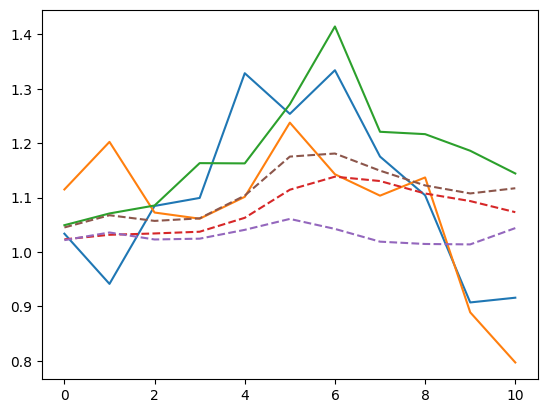

In [ ]:
from isssm.kalman import kalman, smoother
x_filt, Xi_filt, x_pred, Xi_pred = kalman(z_meis, x0, Sigma, Omega_meis, A, B)
x_smooth, Xi_smooth = smoother(x_filt, Xi_filt, x_pred, Xi_pred, A)


plt.plot(x)
plt.plot(x_smooth, linestyle="--")
plt.show()

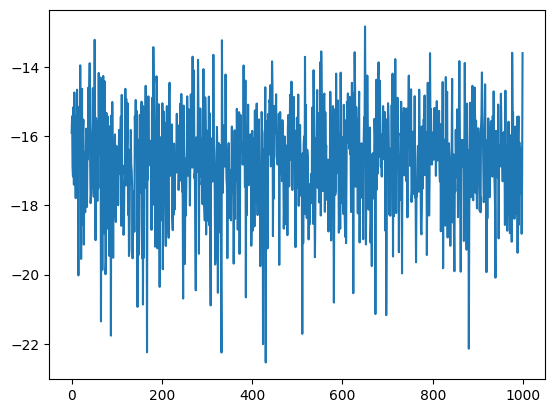

In [ ]:
N = 1000
samples = FFBS(z_meis, x0, Sigma, Omega_meis, A, B, 1000, jrn.PRNGKey(423423))

vB = partial(vmap(jnp.matmul), B)

s = vmap(vB)(samples)

vlw = vmap(log_weights, (0, None, None, None, None, None))
lw = vlw(s, y, xi_fun, dist, z, Omega)
plt.plot(lw)
plt.show()

In [ ]:
from isssm.importance_sampling import ess_lw

ess_lw(lw) / lw.shape[0] * 100

Array(26.778198, dtype=float32)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()